## Описание проекта

#### Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

#### Изучим:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## План

#### <a href='#Шаг 1'>Шаг 1. Загрузим данные и подготовим их к анализу</a>
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный.

#### <a href='#Шаг 2'>Шаг 2. Построим отчёты и посчитаем метрики</a>
<a href='#Шаг 2_1'>Продукт</a>
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?
- <a href='#Шаг 2_1_0'>Вывод</a>

<a href='#Шаг 2_2'>Продажи</a>
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)
- <a href='#Шаг 2_2_0'>Вывод</a>

<a href='#Шаг 2_3'>Маркетинг</a>
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)
- <a href='#Шаг 2_3_0'>Вывод</a>

Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

#### <a href='#Шаг 3'>Шаг 3. Напишем вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег?</a>
- Какие источники/платформы мы бы порекомендовали?
- Объясним свой выбор: на какие метрики мы ориентируемся? Почему?
- Какие выводы мы сделали, узнав значение метрик?

#### <a href='#Шаг 4'>Шаг 4. Общий вывод</a>



## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

<a id='Шаг 1'></a>
## Шаг 1. Загрузим данные и подготовим их к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt
from io import BytesIO
import requests

### Таблица visits

Загрузим данные и изучим их

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
211935,desktop,2017-10-23 13:15:00,3,2017-10-23 12:42:00,15168361461128054514
300013,touch,2017-06-15 17:00:00,1,2017-06-15 16:32:00,2855010431550073622
205379,touch,2017-07-31 23:50:00,9,2017-07-31 23:48:00,17875524458089350830
333218,desktop,2017-10-21 10:15:00,2,2017-10-21 09:36:00,4081811229730867308
335962,desktop,2018-02-25 12:14:00,4,2018-02-25 11:57:00,16123792901922453615


Обратим внимание на типы данных и названия колонок

In [3]:
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

Приведем названия колонок к нижнему регистру и уберем пробелы

In [4]:
visits = visits.rename(columns = {'Device': 'device', 'End Ts': 'end_dt', 'Source Id': 'source_id', 'Start Ts': 'start_dt', 'Uid': 'uid'})
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_dt       359400 non-null object
source_id    359400 non-null int64
start_dt     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Изменим тип данных для начала и конца сессии на datetime

In [5]:
visits['end_dt'] = pd.to_datetime(visits['end_dt'])
visits['start_dt'] = pd.to_datetime(visits['start_dt'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_dt       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_dt     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Таблица orders

Загрузим данные и изучим их

In [6]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.sample(5)

,Buy Ts,Revenue,Uid
7604,2017-09-12 22:48:00,3.05,13546200258327265435
23138,2017-12-10 09:03:00,9.78,295686250893536802
49267,2018-05-28 12:39:00,7.33,9737640335185488211
47558,2018-05-16 23:24:00,0.24,17074500699621201775
7563,2017-09-12 14:42:00,4.40,11576574646177317433


In [7]:
orders.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

Приведем названия колонок к нижнему регистру и уберем пробелы

In [8]:
orders = orders.rename(columns = {'Buy Ts': 'buy_dt', 'Revenue': 'revenue', 'Uid': 'uid'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_dt     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Изменим тип данных для даты покупки на datetime

In [9]:
orders['buy_dt'] = pd.to_datetime(orders['buy_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_dt     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Таблица costs

In [10]:
costs = pd.read_csv('/datasets/costs.csv')
costs.sample(5)

,source_id,dt,costs
1218,4,2017-10-08,154.38
915,3,2017-12-07,682.59
1680,5,2018-01-15,180.38
2288,10,2017-09-18,20.14
814,3,2017-08-28,276.51


In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


названия столбцов в порядке, изменим тип данных в дате на datetime

In [12]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Вывод
- видим, что только визиты и затраты разбиты по источникам, надо будет подумать, как разбить выручку по источникам для анализа
- по платформам разбиты только визиты, выручку, скорее всего удастся разбить по платформам, а вот расходы - уже нет
- у всех таблиц иммется по два ключа (месяц операции и уникаольный код пользователя)
- в целом, данные в таблицах корректные, нет пропусков, необходимо только переименовать столбцы и типы данных в талблице costs


<a id='Шаг 2'></a>
## Шаг 2. Построим отчёты и посчитаем метрики


<a id='Шаг 2_1'></a>
### Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Сколько людей пользуются в день, неделю, месяц?

Вытащим из даты столбцы с данными по дате, неделе, месяцу и году

In [13]:
visits['date'] = visits['start_dt'].dt.date
visits['week'] = visits['start_dt'].dt.week
visits['month'] = visits['start_dt'].dt.month
visits['year'] = visits['start_dt'].dt.year

Посчитаем пользовательскую активность

In [14]:
dau = visits.groupby('date')['uid'].nunique().mean().round()
wau = visits.groupby('week')['uid'].nunique().mean().round()
mau = visits.groupby('month')['uid'].nunique().mean().round()
print('Количество уникальных пользователей в день:', dau)
print('Количество уникальных пользователей в неделю:', wau)
print('Количество уникальных пользователей в месяц:', mau)

Количество уникальных пользователей в день: 908.0
Количество уникальных пользователей в неделю: 5825.0
Количество уникальных пользователей в месяц: 23228.0


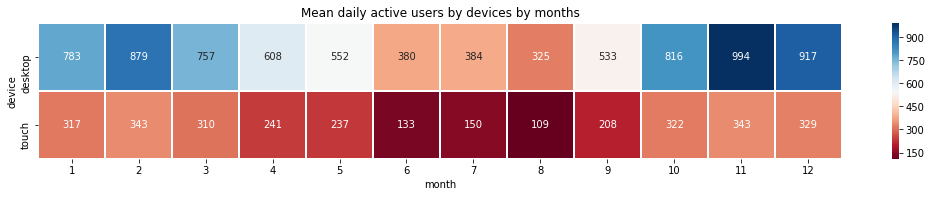

In [15]:
dau_monthly = visits.groupby(['device','month','date'])['uid'].nunique().reset_index()
dau_monthly = dau_monthly.groupby(['device','month'])['uid'].mean().unstack().round()

plt.figure(figsize=(18, 2.5))
plt.title('Mean daily active users by devices by months')
sns.heatmap(dau_monthly,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white')

Посчитаем регулярность использования вашего приложения

In [16]:
sticky_factor_w = dau/wau
sticky_factor_m = dau/mau
print('регулярность использования в неделю "{:.2%}"'.format(sticky_factor_w))
print('регулярность использования в месяц: "{:.2%}"'.format(sticky_factor_m))

регулярность использования в неделю "15.59%"
регулярность использования в месяц: "3.91%"


#### Вывод
- Количество уникальных пользователей в день: 908.0
- Количество уникальных пользователей в неделю: 5825.0
- Количество уникальных пользователей в месяц: 23228.0

- регулярность использования в неделю: 15.59%
- регулярность использования в месяц: 3.91%

#### Сколько сессий в день?

In [17]:
spd = visits.groupby('date')['uid'].count().median().round()
print('Среднее количество сессий в день:', spd)

Среднее количество сессий в день: 1003.0


Посмотрим с каких девайсов наш сайт посещают чаще

In [18]:
spd_dev = visits.groupby(['date','device'])['uid'].count().reset_index()
spd_dev = spd_dev.groupby('device')['uid'].median().reset_index()
spd_dev.columns = ['device','n_session']
spd_dev

,device,n_session
0,desktop,711
1,touch,278


Видим, что пользвоатели чаще посещают наш сайт с компьютеров, нежели с телефонов

Проанализируем посещение нашего сайта с разных девайсов по периодам

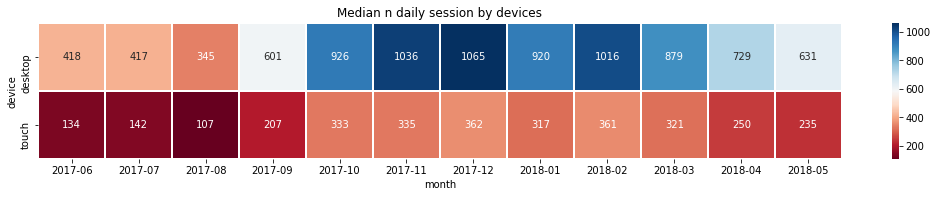

In [19]:
visits_dev = visits[['device','uid','date']].copy()
visits_dev = visits_dev.groupby(['device','date'])['uid'].count().reset_index()
visits_dev['month'] = visits_dev['date'].astype('datetime64[M]')
visits_dev['month'] = visits_dev['month'].dt.strftime('%Y-%m')
visits_dev = visits_dev.groupby(['month','device'])['uid'].median().unstack().T

plt.figure(figsize=(18, 2.5))
plt.title('Median n daily session by devices')
sns.heatmap(visits_dev,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white')

На графике видно, что основной ажиотаж приходится на холодные месяцы, очевидно, так как люди начинают предпочитать мероприятия в помещениях (кино,театры, клубы, выставки) активностям на открытом воздухе

Посмотрим еще посещаемость по источникам трафика

In [20]:
spd_sid = visits.groupby(['date','source_id'])['uid'].count().reset_index()
spd_sid = spd_sid.groupby('source_id')['uid'].median().reset_index()
spd_sid.columns = ['source_id','n_session']
spd_sid.sort_values(by = 'n_session', ascending = False)

,source_id,n_session
3,4,300
2,3,238
4,5,181
1,2,131
0,1,91
8,10,23
7,9,22
5,6,1
6,7,1


Видим, что лидируют источники 4,3,5

Построим график по источникам в разрезе периодов

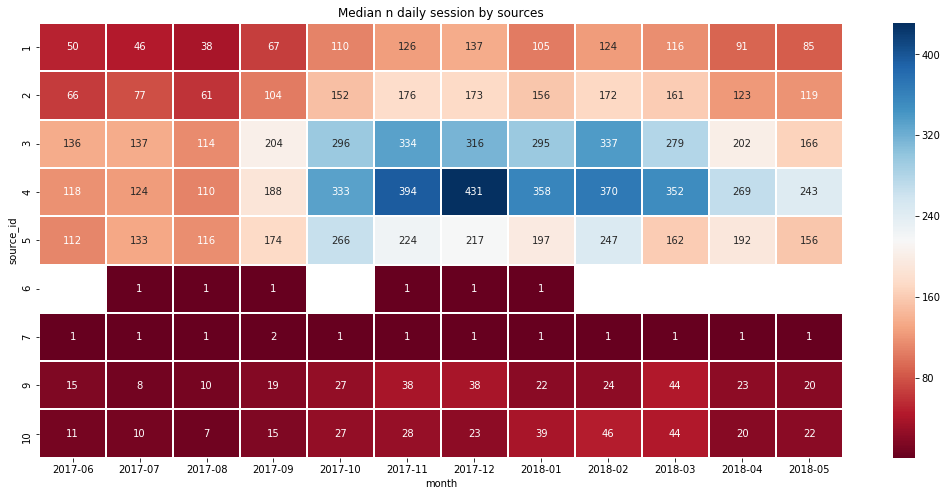

In [21]:
visits_sid = visits[['source_id','uid','date']].copy()
visits_sid = visits_sid.groupby(['source_id','date'])['uid'].count().reset_index()
visits_sid['month'] = visits_sid['date'].astype('datetime64[M]')
visits_sid['month'] = visits_sid['month'].dt.strftime('%Y-%m')
visits_sid = visits_sid.groupby(['month','source_id'])['uid'].median().unstack().T

plt.figure(figsize=(18, 8))
plt.title('Median n daily session by sources')
sns.heatmap(visits_sid,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white')

Видим, что никаких аномалий нет, все данные подвержены общей тенденции к увеличению просмотров в холодное время

#### Вывод

- Среднее количество посещений в день - 1000 
- Посещения с компьютера сильно превышают посещения с телефона 711 против 278
- Количество посещений сильно вырастает в холодное время суток (явно связано с образом жизни людей в холодное время)
- Лидеры по источникам посещения 4,3,5 (занимают около 60% всех посещений)

#### Сколько длится одна сессия?

In [22]:
visits['duration'] = (visits['end_dt'] - visits['start_dt']).dt.seconds
print('Средняя продолжительность сессии:', visits['duration'].mean().round(),'сек.')

Средняя продолжительность сессии: 644.0 сек.


Рассмотрим среднюю продолжительность в разрезе девайсов

In [23]:
dur_dev = visits.groupby('device')['duration'].mean().round().reset_index()
dur_dev

,device,duration
0,desktop,704.0
1,touch,480.0


Как и в случае с количестов сессий, компьютеры явно превосходят телефоны по продолжительности сессий

Проанализируем продолжительность по периодам

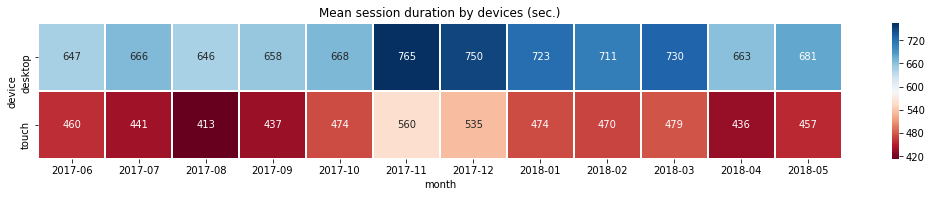

In [24]:
visits_dur = visits[['device','duration','date']].copy()
visits_dur['month'] = visits_dur['date'].astype('datetime64[M]')
visits_dur['month'] = visits_dur['month'].dt.strftime('%Y-%m')
visits_dur = visits_dur.groupby(['month','device'])['duration'].mean().unstack().T

plt.figure(figsize=(18, 2.5))
plt.title('Mean session duration by devices (sec.)')
sns.heatmap(visits_dur,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white')

Видим уже знакомую нам "сезонность" - в холодное время люди больше времени проводят на нашем сайте

Посмотрим из каких источников трафика посетители проводят больше времени на сайте

In [25]:
visits.groupby('source_id')['duration'].mean().round().sort_values(ascending = False).reset_index()

,source_id,duration
0,6,1370.0
1,1,1039.0
2,2,845.0
3,10,662.0
4,7,607.0
5,9,573.0
6,3,573.0
7,4,560.0
8,5,527.0


Лидеры - 6,1,2

Проанализируем "сезонность" по источникам трафика

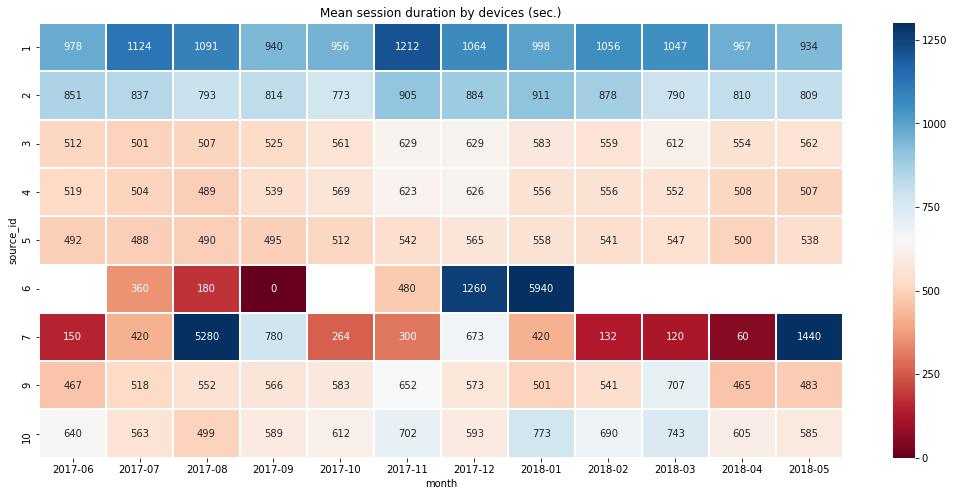

In [26]:
visits_dur_sid = visits[['source_id','duration','date']].copy()
visits_dur_sid['month'] = visits_dur_sid['date'].astype('datetime64[M]')
visits_dur_sid['month'] = visits_dur_sid['month'].dt.strftime('%Y-%m')
visits_dur_sid = visits_dur_sid.groupby(['month','source_id'])['duration'].mean().unstack().T

plt.figure(figsize=(18, 8))
plt.title('Mean session duration by devices (sec.)')
sns.heatmap(visits_dur_sid,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 1300,
            vmin=0)

Как мы можем видеть, есть пару больших выбросов в августе 2017 года по источнику 7 и в январе 2018 года по источнику 6 (надо подробнее изучить источники, так как по источнику 6 имеются как пропуски, так и очень высокие значения)

In [27]:
visits.groupby('duration')['duration'].count().sort_values(ascending = False).head(5)

duration
60     53029
0      35794
120    35748
180    26672
240    21085
Name: duration, dtype: int64

#### Вывод
- Средняя продолжительность сессии (644 сек.) около 10 минут
- Продолжительность посещений с компьютера превосходит продолжительность посещений с телефона (704 сек против 480 сек)
- Сохраняется тенденция с увеличением продолжительности посещения сайта в холодное время года
- Лидеры среди источников по продолжительности - 6,1,2
- Самая частая продолжительность сессии - 60 сек, второе место - 0 сек. Видно это связано с округлением в меньшую сторону (за это время люди успевают посмотреть расписание или уточнить место мероприятия. Необзодимо испольщовать моду как основную метрику, так как она миеньше всего подвержена выбросам


#### Как часто люди возвращаются?

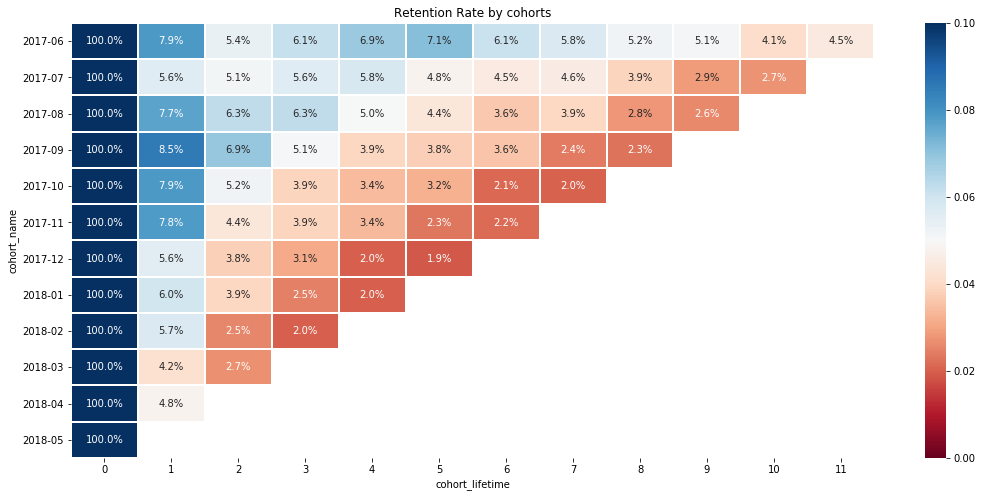

In [28]:
visits['start_month'] = visits['start_dt'].astype('datetime64[M]')

cohorts = visits.groupby('uid')['start_month'].min().reset_index()
cohorts.columns = ['uid', 'cohort_name']
visits = visits.merge(cohorts, on = 'uid')

visits_grouped= visits.groupby(['cohort_name','start_month'])['uid'].nunique().astype('int').reset_index()
visits_grouped['cohort_lifetime'] = (visits_grouped['start_month'] - visits_grouped['cohort_name']) / np.timedelta64(1,'M')
visits_grouped['cohort_lifetime'] = visits_grouped['cohort_lifetime'].round().astype('int')
visits_grouped['cohort_name'] = visits_grouped['cohort_name'].dt.strftime('%Y-%m')

initial_users = visits_grouped.query('cohort_lifetime == 0')[['cohort_name','uid']]
initial_users.columns = ['cohort_name', 'initial_users']

visits_grouped = visits_grouped.merge(initial_users, on = 'cohort_name')
visits_grouped['retention'] = visits_grouped['uid'] / visits_grouped['initial_users']

ret_pivot = visits_grouped.pivot_table(index = 'cohort_name',
                                       columns = 'cohort_lifetime',
                                       values = 'retention')
plt.figure(figsize=(18, 8))
plt.title('Retention Rate by cohorts')
sns.heatmap(ret_pivot,
            annot=True,
            fmt='.1%',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 0.1,
            vmin=0)

На графике видно, что уже на следующий месяц после первого посещения мы теряем более 90% посететилей, необходимо проанализировать проблему, так как цифры действительно ужасающие

<a id='Шаг 2_1_0'></a>
#### Вывод
Пользователи

- Количество уникальных пользователей в день: 908
- Количество уникальных пользователей в неделю: 5 825
- Количество уникальных пользователей в месяц: 23 228
- регулярность использования в месяц: 15.59%
- регулярность использования в месяц: 3.91%

Посещения

- Среднее количество посещений в день - 1000 
- Посещения с компьютера сильно превышают посещения с телефона 711 против 278
- Количество посещений сильно вырастает в холодное время суток (явно связано с образом жизни людей в холодное время)
- Лидеры по источникам посещения 4,3,5 (занимают около 60% всех посещений)

Продолжительность

- Средняя продолжительность сессии (644 сек.) около 10 минут
- Продолжительность посещений с компьютера превосходит продолжительность посещений с телефона (704 сек против 480 сек)
- Сохраняется тенденция с увеличением продолжительности посещения сайта в холодное время года
- Лидеры среди источников по продолжительности - 6,1,2
- Самая частая продолжительность сессии - 60 сек, второе место - 0 сек. Видно это связано с округлением в меньшую сторону (за это время люди успевают посмотреть расписание или уточнить место мероприятия

Возвращаемость

-Необходимо обратить внимание на резкое падение посещаемости уже на следующий месяц после регистрации 


<a id='Шаг 2_2'></a>
### Продажи

- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

#### Когда люди начинают покупать?

Посчитаем промежуток между началом сессии и покупкой и посмотрим на его распределение

In [29]:
first_buy = orders.groupby('uid')['buy_dt'].min().reset_index()
first_buy.columns = ['uid', 'first_visit']

orders = orders.merge(first_buy, how = 'left', on = 'uid')
orders['gap'] = (orders['buy_dt'] - orders['first_visit']).dt.seconds 
orders['gap'].describe().round()

count    50415.0
mean     10429.0
std      23368.0
min          0.0
25%          0.0
50%          0.0
75%       2640.0
max      86340.0
Name: gap, dtype: float64

Из описательной части мы видим, что в среднем люди покупают в первую минуту (видимо это билеты в кино или на концерт)

посмотрим какую долю занимают моментальные покупки

In [30]:
orders_table = orders['gap'].value_counts(normalize = True).head(5).reset_index()
orders_table.columns = ['minutes','%']
orders_table.style.format({'%': "{:.1%}"})

,minutes,%
0,0,72.5%
1,4680,0.1%
2,720,0.1%
3,660,0.1%
4,3900,0.1%


#### Вывод
- Люди в основном производят покупку в течение первой минуты на сайте
- Доля таких покупок 72,5 %

#### Сколько раз покупают за период?

Уберем из данных 6 месяц 2018 года, так как он вне рассматриваемого периода (год)

In [31]:
orders = orders.query('buy_dt <= "2018-06-01"')
orders[orders['revenue'] == 0]['revenue'].count()

51

Проверили на нулевые значения выручку, возможно использовалась скидка или промокод, или округление очень маленькой суммы, ну и так как их всего 51 позиция - это около 0,1% - удалять не станем

Посмотрим, сколько покупок люди делают в разные отрезки времени

In [32]:
orders['date'] =  orders['buy_dt'].dt.date
orders['week'] =  orders['buy_dt'].dt.week
orders['month'] =  orders['buy_dt'].dt.month
orders['year'] =  orders['buy_dt'].dt.year

DC = orders.groupby('date')['revenue'].count()
DC_describe = DC.describe().reset_index()
DC_describe.columns = ['index','daily_count']

WC = orders.groupby(['year','week'])['revenue'].count()
WC_describe = WC.describe().reset_index()
WC_describe.columns = ['index','weekly_count']

MC = orders.groupby(['year','month'])['revenue'].count()
MC_describe = MC.describe().reset_index()
MC_describe.columns = ['index','monthly_count']

purchases_count = pd.merge(DC_describe,WC_describe, on = 'index')
purchases_count = purchases_count.merge(MC_describe, on = 'index')
purchases_count.round()

,index,daily_count,weekly_count,monthly_count
0,count,363.0,53.0,12.0
1,mean,139.0,951.0,4201.0
2,std,77.0,396.0,1512.0
3,min,15.0,314.0,1807.0
4,25%,83.0,636.0,3046.0
5,50%,136.0,991.0,4534.0
6,75%,177.0,1257.0,5409.0
7,max,814.0,1894.0,6218.0


В среднем люди делают:
- 136 покупок в день
- 991 покупку в неделю
- 4 534 покупок в месяц

Проведем когортный анализ, посмотрим, как распределилось количество покупок по когортам по продолжительности жизни когорты

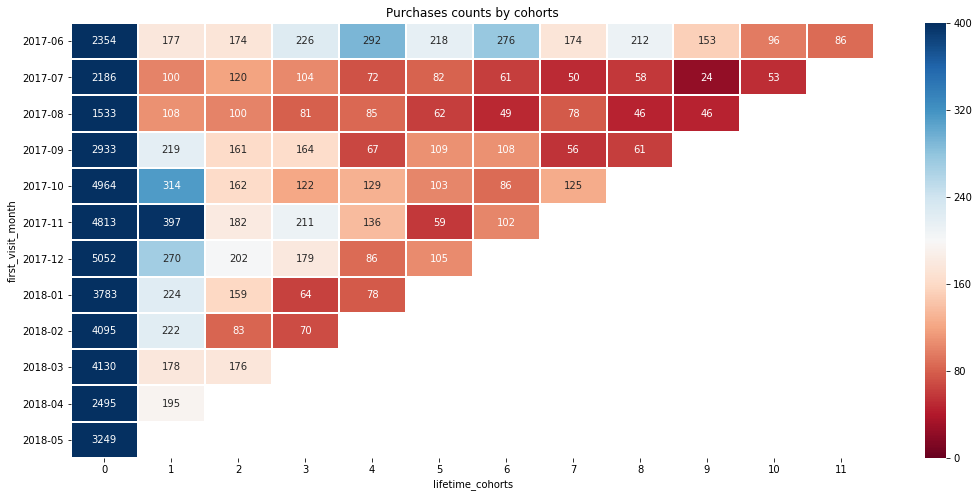

In [33]:
orders['first_visit_month'] = orders['first_visit'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_dt'].astype('datetime64[M]')

orders_grouped = orders.groupby(['buy_month','first_visit_month']).agg({'revenue':['count','sum']}).reset_index()
orders_grouped.columns =['buy_month','first_visit_month','count','sum']
orders_grouped['lifetime_cohorts'] = (orders_grouped['buy_month'] - orders_grouped['first_visit_month'])/ np.timedelta64(1,'M')
orders_grouped['lifetime_cohorts'] = orders_grouped['lifetime_cohorts'].round().astype('int')
orders_grouped['first_visit_month'] = orders_grouped['first_visit_month'].dt.strftime('%Y-%m')

orders_counts_pivot = orders_grouped.pivot_table(index = 'first_visit_month',
                                                 columns = 'lifetime_cohorts',
                                                 values = 'count')

plt.figure(figsize=(18, 8))
plt.title('Purchases counts by cohorts')
sns.heatmap(orders_counts_pivot,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 400,
            vmin=0)

Из графика видим, что основную часть покупок посетители делают в первый месяц посещения сайта, после чего количество покупок резко снижается 

Сделаем срез только по когортам существеющим более 6 мес. и посмотрим какая когорта имеет больше покупок за полгода

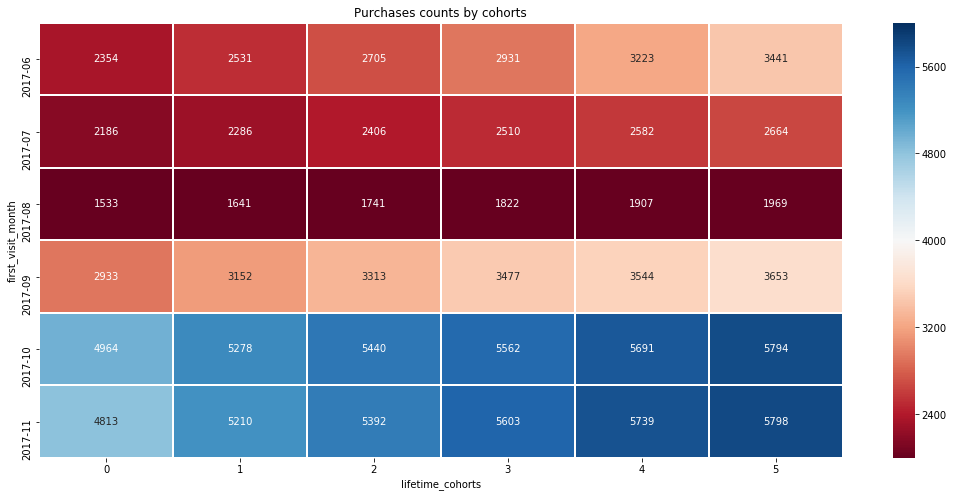

In [34]:
orders_counts_pivot_cumsum = orders_counts_pivot.cumsum(axis =1)
slice = orders_counts_pivot_cumsum.iloc[0:6, 0:6]
plt.figure(figsize=(18, 8))
plt.title('Purchases counts by cohorts')
sns.heatmap(slice,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 6000,
            vmin=2000)

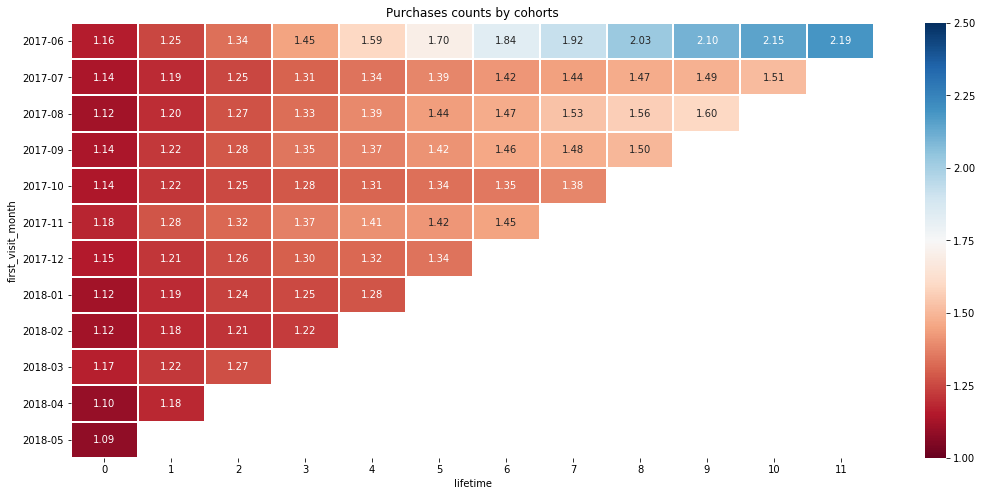

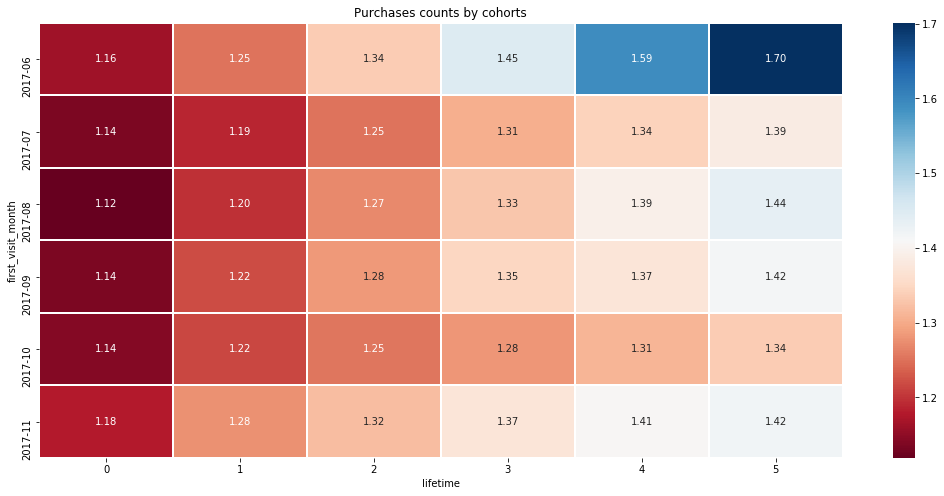

In [35]:
ppv = orders.groupby(['first_visit_month','buy_month']).agg({'uid':'count'}).reset_index()
ppv.columns = ['first_visit_month','buy_month','count']
ppv['first_visit_month'] = pd.to_datetime(ppv['first_visit_month'])
ppv['lifetime'] = (ppv['buy_month'] - ppv['first_visit_month'])/ np.timedelta64(1,'M')
ppv['lifetime'] = ppv['lifetime'].round().astype('int')

buyers_counts = orders.groupby('first_visit_month')['uid'].nunique().reset_index()
buyers_counts.columns = ['first_visit_month','n_buyers']

ppv_table = pd.merge(ppv,buyers_counts, on = 'first_visit_month')
ppv_table['ppv'] = ppv_table['count'] / ppv_table['n_buyers']

ppv_table['first_visit_month'] = ppv_table['first_visit_month'].dt.strftime('%Y-%m')

ppv_pivot = ppv_table.pivot_table(index ='first_visit_month',
                      columns = 'lifetime',
                      values = 'ppv').cumsum(axis = 1)

plt.figure(figsize=(18, 8))
plt.title('Purchases counts by cohorts')
sns.heatmap(ppv_pivot,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 2.5,
            vmin=1)

slice_ppv = ppv_pivot.iloc[0:6, 0:6]

plt.figure(figsize=(18, 8))
plt.title('Purchases counts by cohorts')
sns.heatmap(slice_ppv,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            )



In [36]:
T = orders.groupby('buy_month')['revenue'].count().reset_index()
T['buy_month'] = T['buy_month'].dt.strftime('%Y-%m')
T.T

,0,1,2,3,4,5,6,7,8,9,10,11
buy_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
revenue,2354,2363,1807,3387,5679,5659,6218,4721,5281,5326,3273,4346


Все также можем наблюдать сезонность в количестве покупок в холодное время года

#### Вывод

В среднем люди делают:
- 136 покупок в день
- 991 покупку в неделю
- 4 534 покупок в месяц

Количество покупок падает более, чем на 90% на следующий месяц после первого визита пользователя

Сезонность коснулась и количества покупок

- Самые успешные когороты по количеству покупок 2017-10 и 2017-11

Уже в первый месяц в среднем посетитель делает больше одной покупки, но даже за полгода количество покупок на одного польщователя не достигает двух

Видим, что больше всего покупок делают представители когороты 2017-11, но количество покупок на одного пользователя самое высокое в когороте 2017-06

#### Какой средний чек?

In [37]:
print('Средний чек:', (orders.revenue.sum()/orders.revenue.count()).round())

Средний чек: 5.0


Посчитаем средний чек по когортам

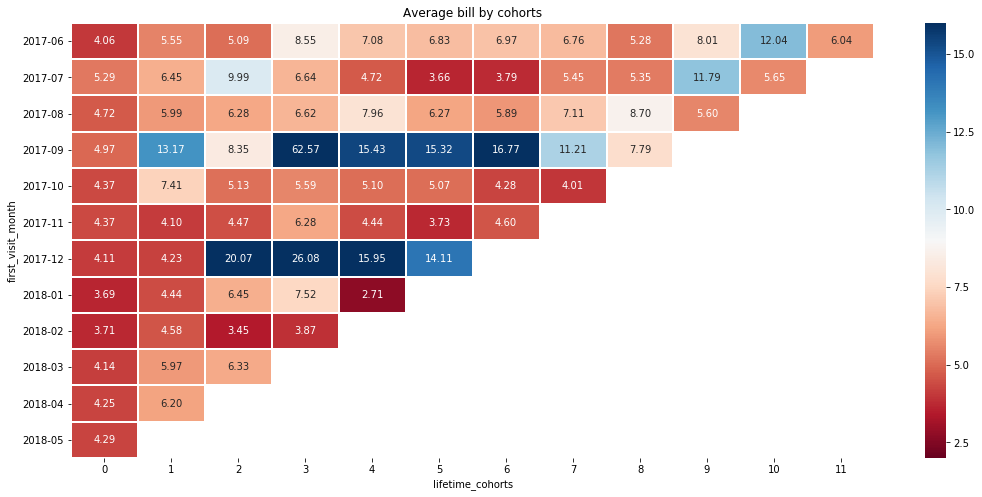

In [38]:
orders_grouped['avg_bill'] = orders_grouped['sum'] / orders_grouped['count']

orders_avg_bill_pivot = orders_grouped.pivot_table(index = 'first_visit_month',
                                                   columns = 'lifetime_cohorts',
                                                   values = 'avg_bill'
                                                   )
plt.figure(figsize=(18, 8))
plt.title('Average bill by cohorts')
sns.heatmap(orders_avg_bill_pivot,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 16,
            vmin=2)

Из графика видим:
- есть аномальные значения (исследуем их)
- прослеживаются две самые выгодные когороты (2017-12 и 2017-09)
- остальные когорты в среднем  приносят нам от 4 до 7 за покупку

In [39]:
orders_avg_bill_pivot.mean(axis = 1).sort_values(ascending = False)

first_visit_month
2017-09    17.285688
2017-12    14.092359
2017-06     6.853978
2017-08     6.513505
2017-07     6.252011
2018-03     5.482008
2018-04     5.226746
2017-10     5.119685
2018-01     4.963399
2017-11     4.571543
2018-05     4.286168
2018-02     3.900908
dtype: float64

Проанализируем аномальные значения

In [40]:
anomaly = orders.query('first_visit_month == "2017-09-01" and buy_month == "2017-12-01"')
anomaly[['revenue','uid']].sort_values(by = 'revenue', ascending = False).head(5)

,revenue,uid
23244,2633.28,5539673724080479777
23165,1195.64,5539673724080479777
24341,604.39,5539673724080479777
21961,402.72,5539673724080479777
22769,360.55,5539673724080479777


отфильтровав выручку по периоду и отсотрировав ее по убыванию обнаруживаем один uid покупающий сразу на большие суммы

In [41]:
anomaly.groupby('uid')['revenue'].sum().sort_values(ascending = False).head(5).reset_index()

,uid,revenue
0,5539673724080479777,9253.70
1,11218248891942632814,153.26
2,8539015707073391293,139.12
3,10246903932085021612,121.67
4,7137696533349307614,106.64


Посмотрев на выручку по данному uid, видим, что это какой-то крупный клиент, необходимо  удержать этого клиента, он может принести нам много денег в будущем, передать информацию в отедл маркетинга

#### Вывод
- Средний чек составляет 5
- Вычислили аномальных клинетов, которые приносят много денег (стоит за них взяться) 
- Средний чек по когортам от 4 до 7


#### Сколько денег приносят? (LTV)

Посчитаем итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок. И построим распределение LTV по когортам

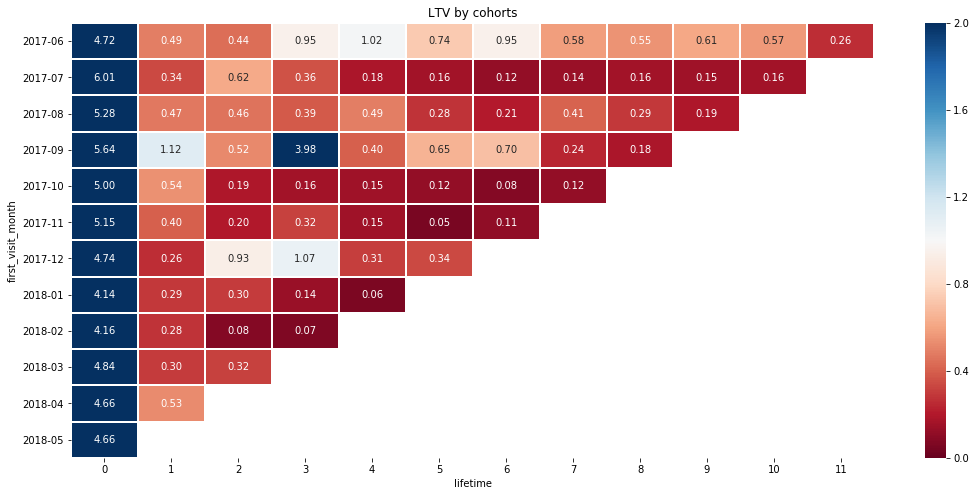

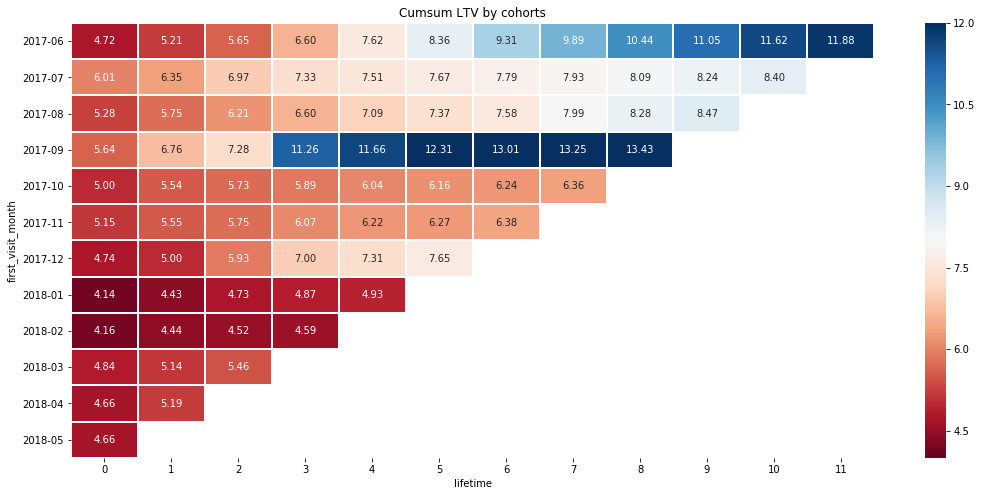

In [42]:
buyers_counts = orders.groupby('first_visit_month')['uid'].nunique().reset_index()
buyers_counts.columns = ['first_visit_month','n_buyers']


ltv = orders.groupby(['first_visit_month','buy_month'])['revenue'].sum().reset_index()
ltv = ltv.merge(buyers_counts, on ='first_visit_month')
ltv['lifetime'] = (ltv['buy_month'] - ltv['first_visit_month']) / np.timedelta64(1,'M')
ltv['lifetime']  = ltv['lifetime'].round().astype('int')
ltv['first_visit_month'] = ltv['first_visit_month'].dt.strftime('%Y-%m')
ltv['ltv'] = ltv['revenue'] / ltv['n_buyers']



ltv_pivot = ltv.pivot_table(index = 'first_visit_month',
                            columns = 'lifetime',
                            values ='ltv').round(2)

plt.figure(figsize=(18, 8))
plt.title('LTV by cohorts')
sns.heatmap(ltv_pivot,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 2,
            vmin=0)

ltv_pivot_cumsum = ltv_pivot.cumsum(axis=1)

plt.figure(figsize=(18, 8))
plt.title('Cumsum LTV by cohorts')
sns.heatmap(ltv_pivot_cumsum,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 12,
            vmin=4)

Отсечем когороты прожишие 6 месяцев и рассмотрим период полгода для того, чтобы данные были сопоставимы

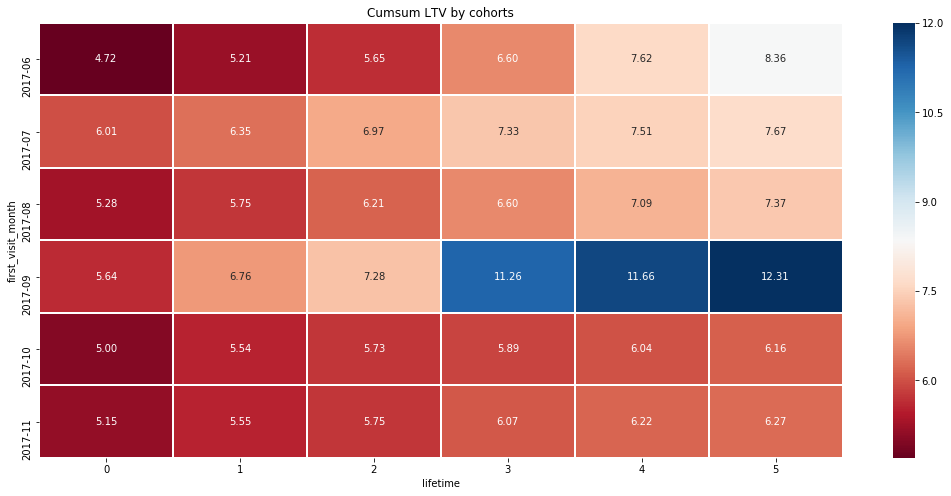

In [43]:
slice_ltv = ltv_pivot_cumsum.iloc[0:6, 0:6]

plt.figure(figsize=(18, 8))
plt.title('Cumsum LTV by cohorts')
sns.heatmap(slice_ltv,
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 12,
            vmin=4.7)

Так как других вводных нет, приравниваем валовую прибыль к выручке. 

После установление рамок в 6 месяцев, можем видеть, что в рамках полгода самыми прибыльными когоротами все также остаются 2017-9 и 2017-6

<a id='Шаг 2_2_0'></a>
#### Вывод

Когда

- Посетители в 72,5% случаев производят покупку на сайте в течение первой минуты

Сколько

- 136 покупок в день
- 991 покупку в неделю
- 4 534 покупок в месяц

Средний чек

- Средний чек составляет 5
- Когорты с самым высоким средним чеком 2017-12 и 2017-09 (за счет аномальных клиентов)
- Есть смысл проводить подобный анализ для вычисления ключевых клиентов

LTV

- Можем выделить две когорты с самым высоким LTV - 2017-09 и 2017-06 


<a id='Шаг 2_3'></a>
### Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)
- Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

#### Сколько денег потратили? Всего / на каждый источник / по времени

Посчитаем, сколько всего денег мы потратили на привлечение клиентов

In [44]:
costs['costs'].sum().round()

329132.0

In [45]:
visits['uid'].nunique()

228169

In [46]:
print('Средняя стоимость привлечения посетителя:',(costs['costs'].sum().round() / visits['uid'].nunique()).round(2))

Средняя стоимость привлечения посетителя: 1.44


Посмотрим, как распределились затраты по источникам и месяцам и посчитаем затраты по источникам накопительным итогом

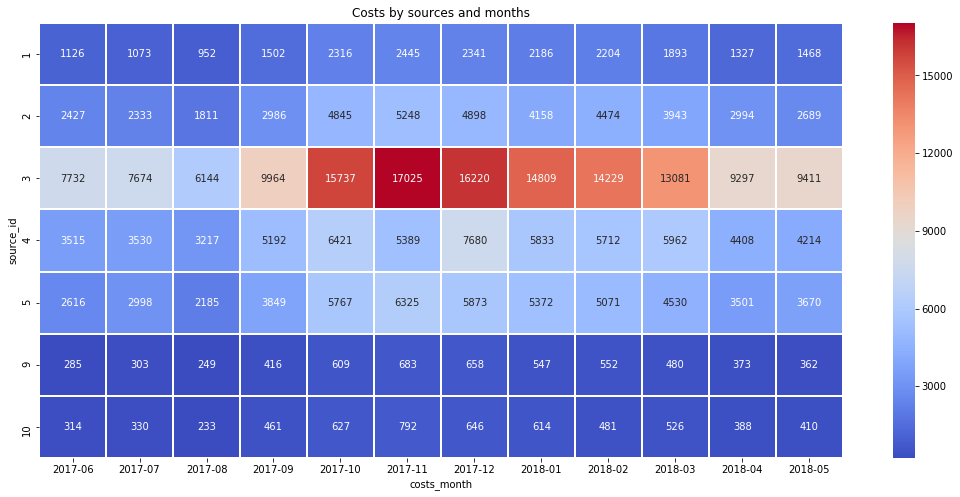

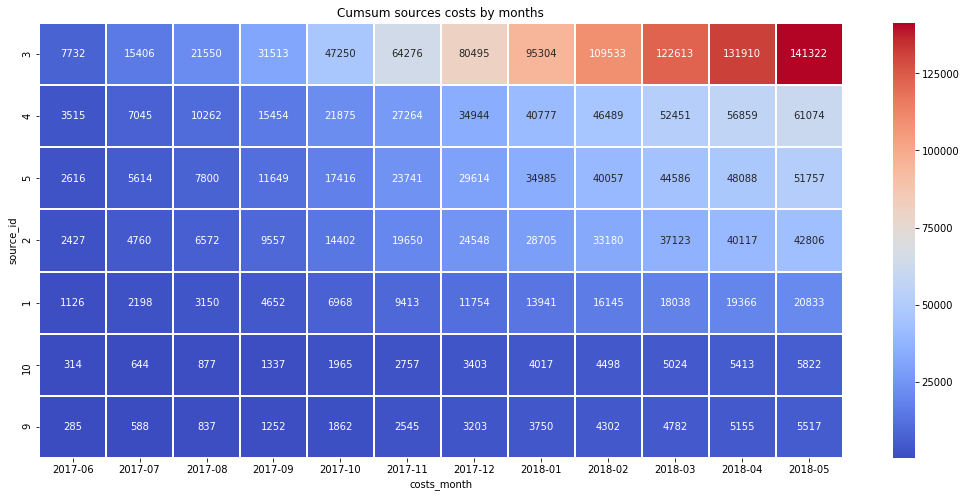

In [47]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs['costs_month'] = costs['costs_month'].dt.strftime('%Y-%m')
costs_grouped = costs.groupby(['costs_month','source_id'])['costs'].sum().reset_index()




costs_pivot = costs_grouped.pivot_table(index = 'source_id',
                                        columns = 'costs_month',
                                        values = 'costs'
                                       )
plt.figure(figsize=(18, 8))
plt.title('Costs by sources and months')
sns.heatmap(costs_pivot,
            annot=True,
            fmt='.0f',
            linewidths=1,
            linecolor='white',
            cmap = "coolwarm")

costs_pivot_cumsum = costs_pivot.cumsum(axis=1).sort_values(by = '2018-05', ascending= False)

plt.figure(figsize=(18, 8))
plt.title('Cumsum sources costs by months')
sns.heatmap(costs_pivot_cumsum,
            annot=True,
            fmt='.0f',
            linewidths=1,
            linecolor='white',
            cmap = "coolwarm")

Посмотрим, в каком месяце мы больше всего тратим на привлечение пользователей.

In [48]:
costs_grouped.groupby('costs_month')['costs'].sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11
costs_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
costs,18015,18240.6,14790.5,24368.9,36322.9,37907.9,38315.4,33518.5,32723,30415.3,22289.4,22224.3


И снова, большинство затрат приходится на зиму-весну

#### Вывод
- Всего было потрачено  329 132 на привелечение 228 169 посетителей
- Средняя стоимость привелечения 1го посетителя 1.44
- больше всего мы тратим денег на привлечение посетителей из источников 3,4,5, особенно сильно выделяется 3, который забирает практически половину затрат
- Большинство затрат на привелечение клиентов приходится на зиму-весну

#### Сколько стоило привлечение одного покупателя из каждого источника?

Рассмотрим стоимость привелечения одного покупателя по источникам

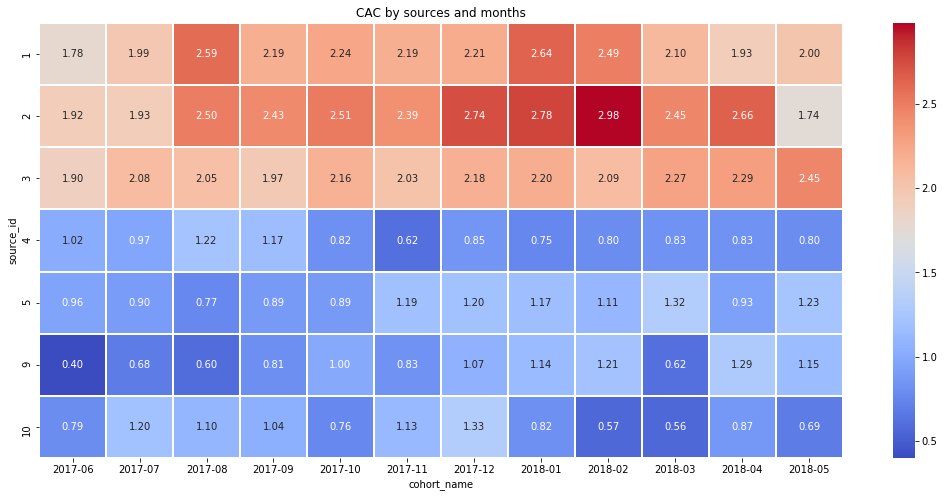

In [49]:
costs_by_source = visits.groupby('uid')['start_dt'].min().reset_index()
costs_by_source.columns = ['uid','firts_date']
costs_by_source = pd.merge(costs_by_source,
                           visits,
                           how = 'left',
                           left_on = ['uid','firts_date'],
                           right_on = ['uid','start_dt'] )

costs_by_source = costs_by_source.groupby(['cohort_name','source_id'])['uid'].nunique().reset_index()
costs_by_source.columns = ['cohort_name','source_id','n_users']
costs_by_source['cohort_name'] = costs_by_source['cohort_name'].dt.strftime('%Y-%m')


costs_2 = costs.groupby(['costs_month','source_id'])['costs'].sum().reset_index()


costs_by_source = pd.merge(costs_by_source,
                           costs_2,
                           how = 'left',
                           left_on = ['cohort_name','source_id'],
                           right_on = ['costs_month','source_id'] )

costs_by_source['cac'] = costs_by_source['costs'] / costs_by_source['n_users']
costs_by_source

cbs_pivot = costs_by_source.pivot_table(index = 'source_id',
                            columns = 'cohort_name',
                            values = 'cac')
plt.figure(figsize=(18, 8))
plt.title('CAC by sources and months')
sns.heatmap(cbs_pivot,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='white',
            cmap = "coolwarm")


In [50]:
cac_table = costs_by_source.groupby('source_id')['cac'].mean().reset_index().round(2).sort_values(by = 'cac', ascending = False)
cac_table

,source_id,cac
1,2,2.42
0,1,2.20
2,3,2.14
4,5,1.05
8,10,0.91
7,9,0.90
3,4,0.89
5,6,NaN
6,7,NaN


Можем наблюдать, что самая высокая стоимость привлечения поcетителей из источников 2,1,3 (от 2.14 до 2.42)

#### На сколько окупились расходы? (ROI)

Рассчитаем рентабельность затрат на маркетинг

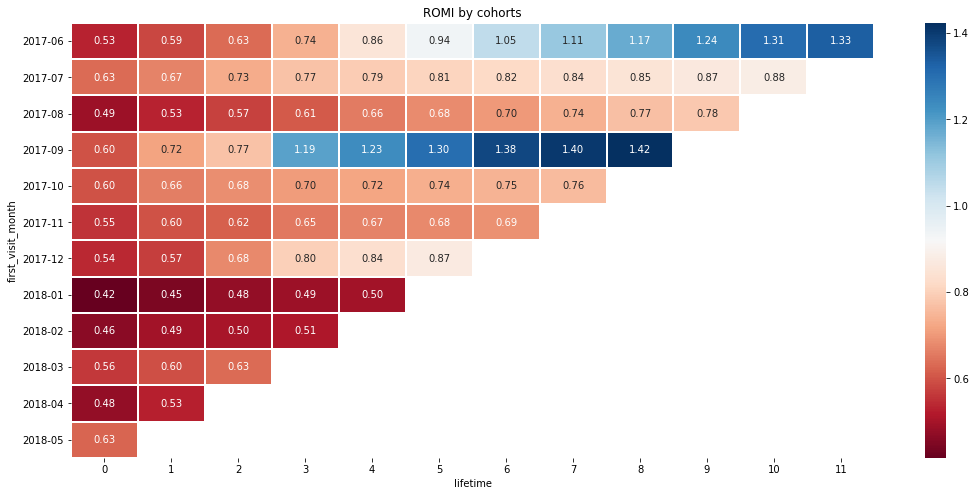

In [51]:
cac_for_romi = costs_by_source.groupby('cohort_name')['costs'].sum().reset_index()

romi = pd.merge(ltv,cac_for_romi, left_on ='first_visit_month', right_on ='cohort_name')
romi['cac'] = romi['costs'] / romi['n_buyers']
romi['romi'] = romi['ltv'] / romi['cac']


romi_pivot = romi.pivot_table(index = 'first_visit_month',
                              columns ='lifetime',
                              values ='romi')
plt.figure(figsize=(18, 8))
plt.title('ROMI by cohorts')
sns.heatmap(romi_pivot.cumsum(axis =1),
            annot=True,
            fmt='.2f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white')

Видим, что окупились только две когорты (2017-06 и 2017-09), причем очевидно, что когорта окупилась раньше первой когороты за счет "аномального" клиента

Посчитаем окупаемость в абсолютных значениях и выручку по когортам

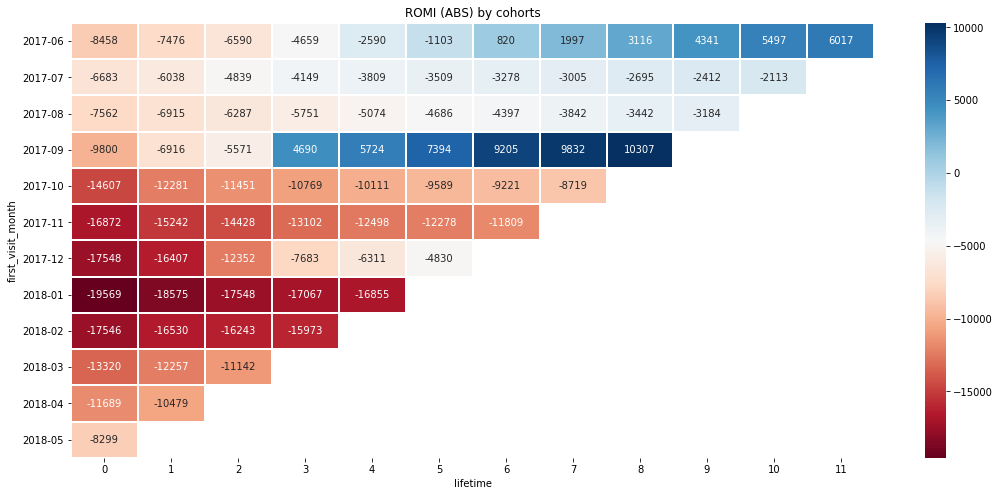

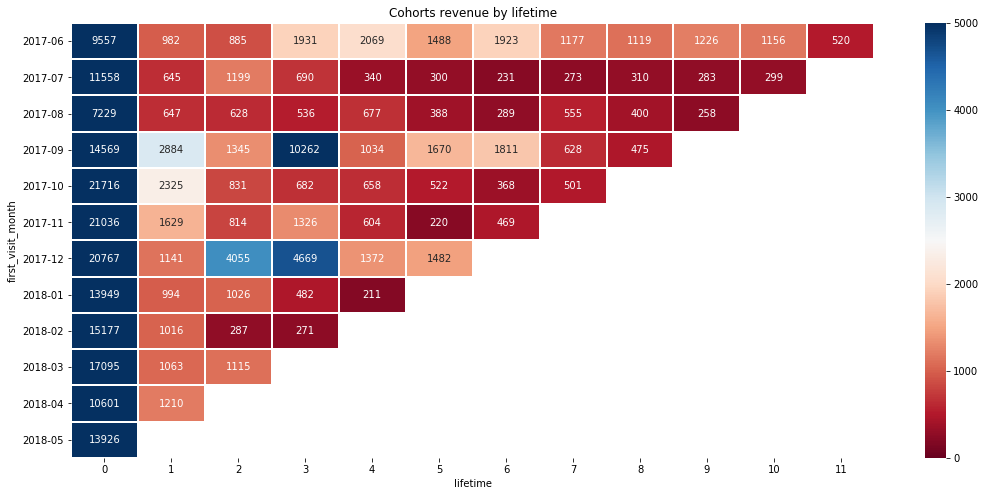

In [52]:
roi_abs = romi.groupby(['first_visit_month','lifetime']).agg({'revenue':'sum','costs':'min'}).reset_index()
roi_abs = roi_abs.assign(
    cohort_costs = lambda x: (np.where(x.lifetime == 0, x.costs, 0)))

roi_abs['abs'] = roi_abs['revenue'] - roi_abs['cohort_costs']

roi_abs_pivot = roi_abs.pivot_table(index = 'first_visit_month',
                    columns = 'lifetime',
                    values = 'abs')

plt.figure(figsize=(18, 8))
plt.title('ROMI (ABS) by cohorts')
sns.heatmap(roi_abs_pivot.cumsum(axis =1),
            annot=True,
            fmt='.0f',
            linewidths=1,
            linecolor='white',
            cmap = 'RdBu')

rev_pivot = roi_abs.pivot_table(index = 'first_visit_month',
                                columns ='lifetime',
                                values = 'revenue')
plt.figure(figsize=(18, 8))
plt.title('Cohorts revenue by lifetime')
sns.heatmap(rev_pivot,
            annot=True,
            fmt='.0f',
            linewidths=1,
            cmap = 'RdBu',
            linecolor='white',
            vmax= 5000,
            vmin=0)

Проверим, сходится ли выручка всего и по всего по когортам, чтобы понять, что мы нигде не ошиблись

In [53]:
roi_abs_pivot.sum(axis =1).sum().round()

-77078.0

In [54]:
(orders['revenue'].sum()-costs['costs'].sum()).round()

-77078.0

Посчитаем среднюю окупаемость по продолжительности жизни когорты

In [55]:
romi_pivot.cumsum(axis=1).mean(axis=0) 

lifetime
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем окупаюся когорты к 9му месяцу, а значит, не стоит переживать за абсолютный убыток за год в размере 77 000, затраты отобьются позже

<a id='Шаг 2_3_0'></a>
#### Вывод

Сколько денег потратили

- Всего было потрачено  329 132 на привелечение 228 169 посетителей
- больше всего мы тратим денег на привлечение посетителей из источников 3,4,5, особенно сильно выделяется 3, который забирает практически половину затрат
- Большинство затрат на привелечение клиентов приходится на зиму-весну

Стоимость привлечения

- Средняя стоимость привелечения 1го посетителя 1.44
- Cамая высокая стоимость привлечения посетителей из источников 2,1,3 (от 2.14 до 2.42)


Окупаемость (ROI)

- Средняя окупаемость 9 месяцев
- Окупились только две когорты (2017-06 и 2017-09)
- Общий убыток составил - 77 000, но эти затраты на привлечение окупятся через некоторое время






<a id='Шаг 3'></a>
## Шаг 3. Вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег?
- Какие источники/платформы мы бы порекомендовали?
- Объясним свой выбор: на какие метрики мы ориентируемся? Почему?
- Какие выводы мы сделали, узнав значение метрик?

#### Платформы

Посмотрим, как метрики тщеславия распределились по платформам

In [56]:
uid_dev = visits.groupby('device')['uid'].nunique().reset_index()
total_comp = uid_dev.merge(dur_dev, on = 'device')
total_comp = total_comp.merge(spd_dev, on = 'device')
total_comp

,device,uid,duration,n_session
0,desktop,164523,704.0,711
1,touch,71345,480.0,278


Видим, что по количеству пользователей, сессий и продолжительности сессий лидирует платформа Desktop

Посмотрим с каких платформ приходят к нам посетители, формирующие нашу выручку.
Посчитаем средний чек по ним и выручку на уникального пользователя

In [57]:
rev_sid_dev = visits.groupby('uid')['start_dt'].min().reset_index()
rev_sid_dev = rev_sid_dev.merge(visits,
                        left_on = ['uid','start_dt'],
                        right_on = ['uid','start_dt'])
rev_sid_dev = rev_sid_dev[['device','source_id','uid']]

ord_sid_dev = orders[['uid','revenue']]
tot_sid_dev = rev_sid_dev.merge(ord_sid_dev, on = 'uid')


tot_dev = tot_sid_dev.groupby('device').agg({'revenue': 'sum', 'uid': ['nunique','count']}).reset_index()
tot_dev.columns = ['device','sum','nunique','count']
tot_dev['rev_by_uid'] = tot_dev['sum'] / tot_dev['nunique']
tot_dev['avg_bill'] = tot_dev['sum'] / tot_dev['count']
tot_dev[['device','avg_bill','rev_by_uid']].round(2)

,device,avg_bill,rev_by_uid
0,desktop,5.16,7.23
1,touch,4.29,5.57


Посмотрим с каких платформ производят больше покупок

In [58]:
ord_by_sid = orders[['buy_dt','revenue','uid']]
vis_by_sid = visits[['uid','start_dt','device','end_dt','source_id']]
ord_by_sid = ord_by_sid.merge(vis_by_sid, on = 'uid', how = 'outer', indicator = True)
ord_by_sid = ord_by_sid.query('_merge == "both"')
ord_by_sid['isin'] = (ord_by_sid['buy_dt'] <= ord_by_sid['end_dt']) & (ord_by_sid['buy_dt'] >= ord_by_sid['start_dt'])
ord_by_sid = ord_by_sid.query('isin == True')
ord_by_sid = ord_by_sid.groupby('device').agg({'revenue': 'sum', 'uid': ['nunique','count']}).reset_index()
ord_by_sid.columns = ['device','sum','nunique','count']
ord_by_sid['avg_bill'] = ord_by_sid['sum'] / ord_by_sid['count']
ord_by_sid['rev_by_uid']=ord_by_sid['sum']/ord_by_sid['nunique']
ord_by_sid[['device','avg_bill','rev_by_uid']].round(2)

,device,avg_bill,rev_by_uid
0,desktop,4.80,5.82
1,touch,3.89,4.40


Тоже лидирует Desktop

Средние меньше, чем значения с каких платформ к нам пришли пользователи, осуществившие покупку, так как в данных имеются покупки без визитов пользователей, видимо, это реализация подписок. Например, у пользователя 12464626743129688638 есть две покупки, хотя визит был только один.

In [59]:
orders.query('uid == 12464626743129688638')

,buy_dt,revenue,uid,first_visit,gap,date,week,month,year,first_visit_month,buy_month
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,0,2017-06-01,22,6,2017,2017-06-01,2017-06-01
413,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00,20160,2017-06-05,23,6,2017,2017-06-01,2017-06-01


In [60]:
visits.query('uid == 12464626743129688638')

,device,end_dt,source_id,start_dt,uid,date,week,month,year,duration,start_month,cohort_name
289855,desktop,2017-06-01 09:12:00,5,2017-06-01 08:51:00,12464626743129688638,2017-06-01,22,6,2017,1260,2017-06-01,2017-06-01


#### Источники

Посмотрим, сколько стоит привлечение пользователя из разных источников

In [61]:
cac_table

,source_id,cac
1,2,2.42
0,1,2.20
2,3,2.14
4,5,1.05
8,10,0.91
7,9,0.90
3,4,0.89
5,6,NaN
6,7,NaN


Посмотрим с каких источников приходят к нам посетители, формирующие нашу выручку.
Посчитаем средний чек по ним и выручку на уникального пользователя

In [62]:
rev_sid_dev = visits.groupby('uid')['start_dt'].min().reset_index()
rev_sid_dev = rev_sid_dev.merge(visits,
                        left_on = ['uid','start_dt'],
                        right_on = ['uid','start_dt'])
rev_sid_dev = rev_sid_dev[['device','source_id','uid']]

ord_sid_dev = orders[['uid','revenue']]

tot_sid_dev = rev_sid_dev.merge(ord_sid_dev, on = 'uid')
tot_sid = tot_sid_dev.groupby('source_id').agg({'revenue': 'sum', 'uid': ['nunique','count']}).reset_index()
tot_sid.columns = ['source_id','sum','nunique','count']
tot_sid['rev_by_uid'] = tot_sid['sum'] / tot_sid['nunique']
tot_sid['avg_bill'] = tot_sid['sum'] / tot_sid['count']
tot_sid[['source_id','avg_bill','rev_by_uid']].round(2).sort_values(by = 'rev_by_uid', ascending = False)

,source_id,avg_bill,rev_by_uid
1,2,7.34,13.38
0,1,5.95,10.72
4,5,5.59,7.59
3,4,4.40,5.51
6,9,3.50,5.29
2,3,4.10,5.20
7,10,2.85,3.35
5,7,1.22,1.22


Видим, что лидируют источники 2,1,5

Посмотрим с из каких источников производят больше покупок

In [63]:
ord_by_sid = orders[['buy_dt','revenue','uid']]
vis_by_sid = visits[['uid','start_dt','device','end_dt','source_id']]

ord_by_sid = ord_by_sid.merge(vis_by_sid, on = 'uid', how = 'outer', indicator = True)
ord_by_sid = ord_by_sid.query('_merge == "both"')
ord_by_sid['isin'] = (ord_by_sid['buy_dt'] <= ord_by_sid['end_dt']) & (ord_by_sid['buy_dt'] >= ord_by_sid['start_dt'])
ord_by_sid = ord_by_sid.query('isin == True')
ord_by_sid = ord_by_sid.groupby('source_id').agg({'revenue': 'sum', 'uid': ['nunique','count']}).reset_index()
ord_by_sid.columns = ['source_id','sum','nunique','count']
ord_by_sid['avg_bill'] = ord_by_sid['sum'] / ord_by_sid['count']
ord_by_sid['rev_by_uid']=ord_by_sid['sum']/ord_by_sid['nunique']

ord_table = ord_by_sid[['source_id','avg_bill','rev_by_uid']].round(2).sort_values(by = 'rev_by_uid', ascending = False)
ord_table

,source_id,avg_bill,rev_by_uid
1,2,7.17,9.14
0,1,5.47,6.62
4,5,4.54,5.23
3,4,3.97,4.22
2,3,3.88,4.01
6,9,3.28,3.59
7,10,2.73,2.84
5,7,1.22,1.22


Также лидируют источники 2,1,5

Сравним доходную и расходную части по источникам, чтобы выявить самые рентабельные источники: 

In [64]:
source_comp = pd.merge(ord_table,cac_table, on = 'source_id')
source_comp['K'] = source_comp['rev_by_uid'] / source_comp['cac']
source_comp.round(2).sort_values(by = 'K', ascending = False)

,source_id,avg_bill,rev_by_uid,cac,K
2,5,4.54,5.23,1.05,4.98
3,4,3.97,4.22,0.89,4.74
5,9,3.28,3.59,0.90,3.99
0,2,7.17,9.14,2.42,3.78
6,10,2.73,2.84,0.91,3.12
1,1,5.47,6.62,2.20,3.01
4,3,3.88,4.01,2.14,1.87
7,7,1.22,1.22,NaN,NaN


Видим, что самые рентабельные источники - 5,4,9

<a id='Шаг 4'></a>
## Шаг 4. Общий вывод


### Какие источники/платформы мы бы порекомендовали?

#### Платформы:

Платформа Desktop лидирует по:

- по количеству сессий
- по количеству активных пользователей
- по продолжительности сессии
- по среднему чеку
- по выручке на уникального пользователя

Платформу Touch необходимо развивать, так как в последнее время пользователи все больше препочитают телефоны и планшеты компьютерам  

#### Источники:

- Источники с самыми высоким средним чеком 2,1,5
- Источники с самыми высокими затратами на привлечение польщователя 2,1,3
- Самые рентабельные источники 2,3,5
    
### Какие выводы мы сделали, узнав значение метрик?

### По метрикам:

#### Средний чек

- Выявлять и брать на контроль ключевых клиентов
- Обратить внимание на сезонность

#### Retention Rate

- Начать бороться с резким падением RT после первого месяца пользования

#### ROMI

- Сократить срок окупаемости когороты

#### DAU/WAU/MAU 

- Развивать платформу Touch

#### CAC и ROMI

- Прекратить финансирование источников 3 и 7
- Развивать источники 6 и 1